The following code is based on the work done by Tess Ferrandez.

https://github.com/TessFerrandez/research-papers/blob/prod/facenet/FaceNet.ipynb

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
cd /content/drive/MyDrive/researchPaperAssignment/models/zeiler

/content/drive/MyDrive/researchPaperAssignment/models/inception


In [41]:
!pip install -q pyyaml h5py

In [43]:
!ls

best_inception_model2.h5  lfw		      training
best_inception_model3.h5  lfw.zip	      training_2
best_inception_model4.h5  meta2.tsv	      training_3
best_inception_model5.h5  meta2_zf.tsv	      Training5
best_inception_model6.h5  meta3.tsv	      vecs2.tsv
best_inception_model.h5   meta4.tsv	      vecs3.tsv
best_zfnet_model2.h5	  meta_train2.tsv     vecs4.tsv
best_zfnet_model.h5	  meta_train.tsv      vecs_train2.tsv
dummy.h5		  meta_zf.tsv	      vecs_train.tsv
history2.csv		  model.h5	      vecs_zf2.tsv
history3.csv		  __pycache__	      vecs_zf.tsv
history4.csv		  test		      zfnet.py
InceptionModel2.ipynb	  TestAccuracy.ipynb
inceptionModel.py	  train


In [44]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pickle
import os

""" Uncomment it to generate embeddings from ZF Model """
from zfnet import create_model

import sys
sys.path.append(os.path.join('..', '..'))

from global_params import *

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
import cv2 as cv

# Load model

In [46]:
# building the model
model = create_model()
# Load the previously saved weights
model.load_weights('best_zfnet_model2.h5')

# Load data and generate embeddings

In [47]:
from PIL import Image, ImageOps
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    identityMetadata = IdentityMetadata
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(identityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = Image.open(path)
    img = img.resize((input_shape[0],input_shape[1]))
    img2 = ImageOps.grayscale(img) 
    return np.asarray(img2)

In [48]:
!ls

best_inception_model2.h5  lfw		      training
best_inception_model3.h5  lfw.zip	      training_2
best_inception_model4.h5  meta2.tsv	      training_3
best_inception_model5.h5  meta2_zf.tsv	      Training5
best_inception_model6.h5  meta3.tsv	      vecs2.tsv
best_inception_model.h5   meta4.tsv	      vecs3.tsv
best_zfnet_model2.h5	  meta_train2.tsv     vecs4.tsv
best_zfnet_model.h5	  meta_train.tsv      vecs_train2.tsv
dummy.h5		  meta_zf.tsv	      vecs_train.tsv
history2.csv		  model.h5	      vecs_zf2.tsv
history3.csv		  __pycache__	      vecs_zf.tsv
history4.csv		  test		      zfnet.py
InceptionModel2.ipynb	  TestAccuracy.ipynb
inceptionModel.py	  train


In [49]:
metadata = load_metadata('train')

In [50]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())
    img = load_image(m.image_path())
    # scale RGB values to interval [0,1]
    img = (img / 255).astype(np.float32)
    img = img.reshape(input_shape)
    # obtain embedding vector for image
    embedded[i] = model.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

/ |                                   #            | 6351 Elapsed Time: 1:21:42

# Visualize distance between images

In [53]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()), cmap='gray', vmin=0, vmax=255)
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()), cmap='gray', vmin=0, vmax=255)

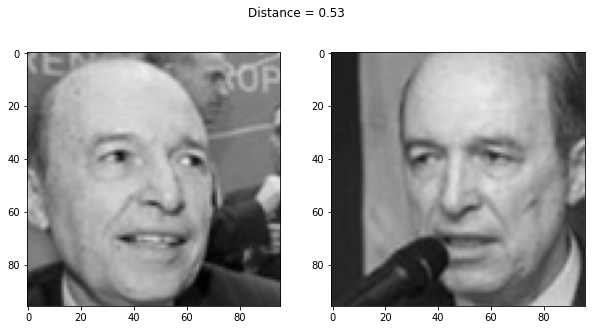

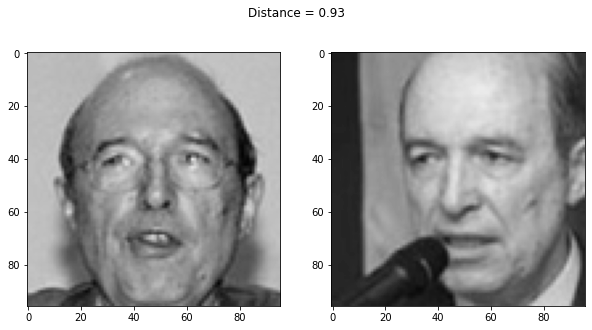

In [54]:
show_pair(98,99)
show_pair(97,99)

# Plot histogram to analyse distance between

1.   Anchor and Positive image
2.   Anchor and Negative image

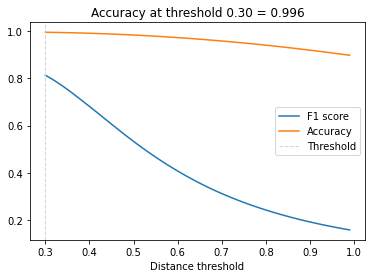

In [55]:
distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

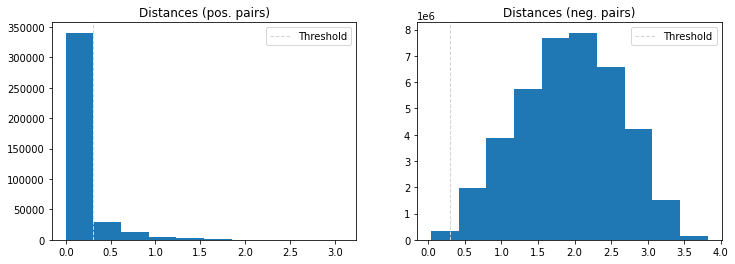

In [56]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Find classification accuracy using SVM and KNN

In [51]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 16 == 0
train_idx = np.arange(metadata.shape[0]) % 16 != 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn*100}, SVM accuracy = {acc_svc*100}\n')

i = 2, k = 1: KNN accuracy = 36.177581863979846, SVM accuracy = 42.69521410579345

i = 2, k = 2: KNN accuracy = 34.1624685138539, SVM accuracy = 42.69521410579345

i = 2, k = 3: KNN accuracy = 34.130982367758186, SVM accuracy = 42.69521410579345

i = 2, k = 4: KNN accuracy = 35.51637279596977, SVM accuracy = 42.69521410579345

i = 2, k = 5: KNN accuracy = 35.7367758186398, SVM accuracy = 42.69521410579345

i = 3, k = 1: KNN accuracy = 37.91312559017941, SVM accuracy = 43.76770538243626

i = 3, k = 2: KNN accuracy = 35.74126534466478, SVM accuracy = 43.76770538243626

i = 3, k = 3: KNN accuracy = 36.59112370160529, SVM accuracy = 43.76770538243626

i = 3, k = 4: KNN accuracy = 37.582625118035885, SVM accuracy = 43.76770538243626

i = 3, k = 5: KNN accuracy = 37.6770538243626, SVM accuracy = 43.76770538243626

i = 4, k = 1: KNN accuracy = 37.8463476070529, SVM accuracy = 44.52141057934509

i = 4, k = 2: KNN accuracy = 35.768261964735515, SVM accuracy = 44.52141057934509

i = 4, k = 3: KN

KeyboardInterrupt: ignored

# Show predictions and analyse error pairs

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = svc.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');

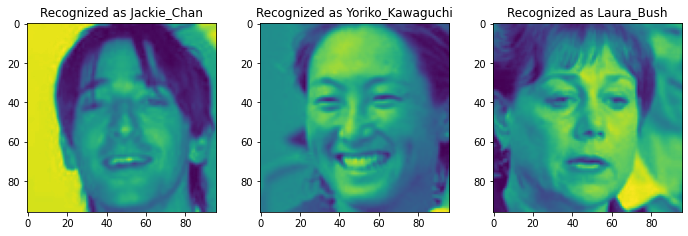

In [ ]:
show_predictions(range(47,50))

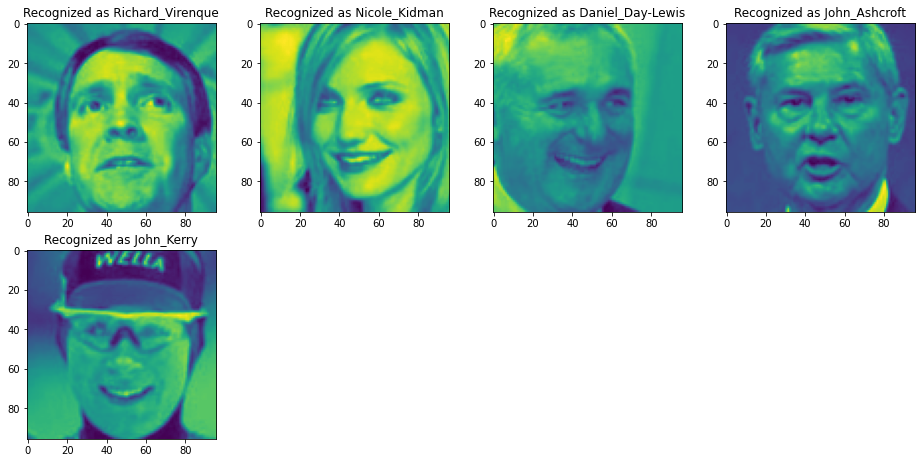

In [ ]:
show_predictions(range(55,60))

[0, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 141, 143, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 218, 233, 243, 248, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275

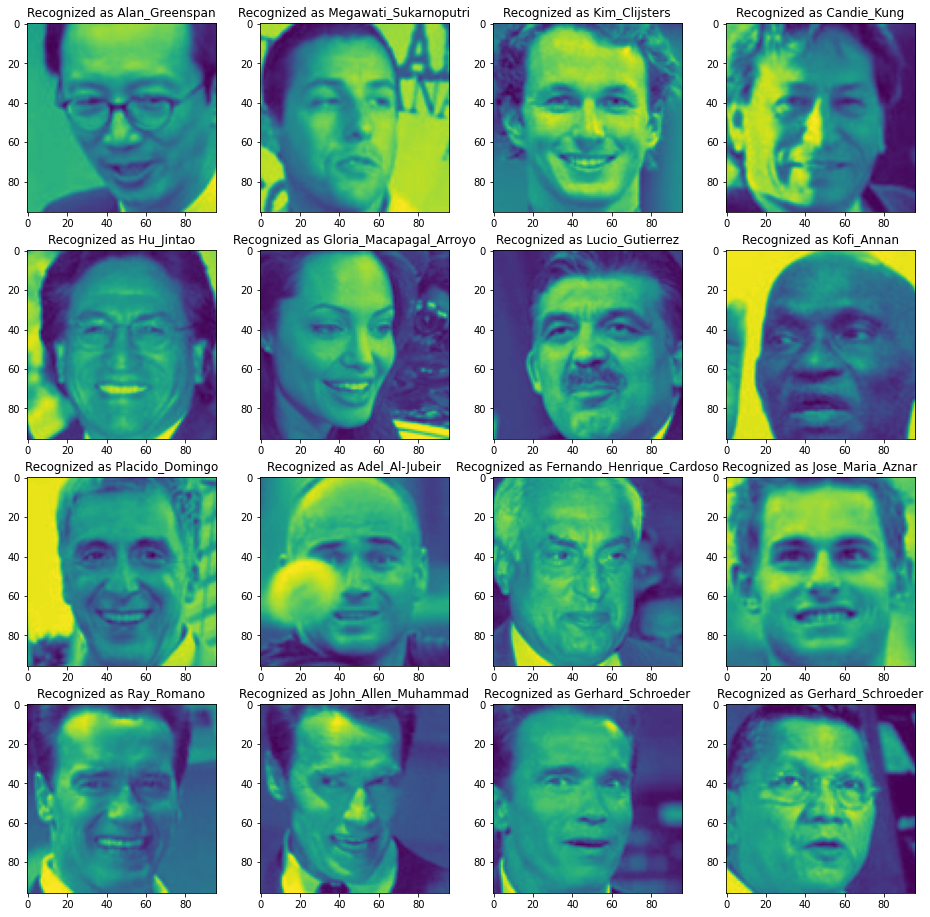

In [ ]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)

#Visualize the embeddings in 2D plane

In [18]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

Output hidden; open in https://colab.research.google.com to view.